In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace
import random
import scipy.optimize as optimize

# Assignment 1
This performance is brought to you by Ivar, Siri and Petter

## Task 3.1

In [2]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model


def chooseDist(dist1,dist2,alpha): # Choose distribution given alpha to be probability of distribution 1.
    if(random.uniform(0,1)>=(1-alpha)):
        return dist1
    return dist2


def genNoise(alpha, N, mean, sigma, beta, magnitude, yreal): # Generate the noise of the signal
    e = np.zeros(N)
    for i in range(0,N):
        dist = chooseDist("Gauss","Laplace",alpha)
        if dist == "Laplace":
            #pdf = laplace_pdf
            pdf = laplace.pdf
            e[i] = magnitude * np.random.laplace(mean, beta)
        elif dist == "Gauss":
            #pdf = gauss_pdf
            pdf = norm.pdf
            e[i] = magnitude * np.random.normal(mean, sigma)
        else:
            raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")
    
    return e

Text(0.5, 1.0, 'Real model!!')

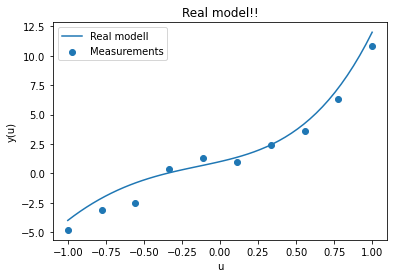

In [3]:
N = 10 # Number of measurements

u = np.linspace(-1,1,N) # "Measured" inputs.

# Define true modell
theta = [1,3,2,5,1] # Real parameters

ymod = arbitrary_poly(theta)


yreal = ymod(u) # Create the modell

# Values for measurements
alpha = 0

beta = 1

mean = 0

magnitude = 1

sigma = 1

e = genNoise(alpha, N, mean, sigma, beta, magnitude, yreal)

y = yreal + e


# Plot
plt.figure()
plt.plot(np.linspace(-1,1),ymod(np.linspace(-1,1)))
plt.scatter(u,y)
plt.legend(["Real modell","Measurements"])
plt.xlabel('u')
plt.ylabel('y(u)')
plt.title('Real model!!')

## Task 3.2

### LS:

In [4]:
# LS function
def LS(degree, output, inputs):
    N = len(inputs)
    u_tensor_0 = np.reshape(inputs,(N,1))

    ones_vec = np.ones((N,1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)
    
    for deg in range(2,degree + 1):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0,deg), axis=1)
    
    # (u^T * u)^-1
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u)
    
    # (u^T * y)
    u_transpose_dot_y = np.dot(u_tensor.T,output)
    
    # (u^T * u)^-1 * (u^T * y)
    est_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
    
    return est_params

### MLE:

In [5]:
def log_lik(param_vec,y,x):
    # This is the function we aim to minimize.
    
    # Param_vec contains the parameters + the standard diviation at the last place
    
    pdf = laplace.pdf # In this task, we only consider laplace distribution
    
    # If the standard deviation is negative, we assume the likelihood to be small. I.e. return a large number
    if param_vec[-1]<0:
        return (1e8)
    
    # The likelihood function values. I.e. the probability of getting y when in x with laplacian distribution and
    # standard deviation as given in param_vec[-1]
    
    lik = pdf(y,
             loc = sum([param*(x**i) for i, param in enumerate(param_vec[:-1])]),
             scale = param_vec[-1])
    
    # If lik consists of all zeros, the log-likelihood will be -infinity. Return a great value
    if all(v == 0 for v in lik):
        return(1e8)
    
    # Return the som of logarithm of the values of lik that are nonzero.
    return(-sum(np.log(lik[np.nonzero(lik)])))

In [6]:
# MLE function
def MLE(degree, inputs, output):
    N = len(output)
    init_params = np.zeros(degree + 2)
    
    init_params[-1] = N
    
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_params, 
                               # options = {'disp':True}, 
                                args = (output,inputs))
    MLE_params = opt_res.x[:-1]
    
    return MLE_params

## Task 3.3

In [7]:
# Want to shuffle the dataset
indexes = np.arange(0,N)
#random.shuffle(indexes)

# Split into three
index_train, index_test = np.split(indexes,2)
print(index_train)

train_set = {'y':y[index_train],'u':u[index_train]}
test_set = {'y':y[index_test],'u':u[index_test]}
print(train_set['y'])

[0 1 2 3 4]
[-4.80792953 -3.14559802 -2.48338578  0.39101993  1.32083786]


In [8]:
# Train models:
def train(estimator_function, degree_list, train_input, train_output):
    # degree_list is a list of ints specifying which degrees to consider
    # input = model input, in this case u
    # output = model output, in this case y
    
    est_models = []
    est_params = []
    for deg in degree_list:
        params = estimator_function(degree = deg, inputs = train_input, output = train_output)
        est_params.append(params)
        mod = arbitrary_poly(params)
        est_models.append(mod)
    return est_models,est_params


# Choose model order

def choose_order(performance_test, degree_list, est_models, test_input, test_output):
    # degree_list is a list of ints specifying which degrees to consider
    # input = model input, in this case u
    # output = model output, in this case y
    # performance test is a function with parameters (measured_output, model_output)
    
    best_performance = 1e8
    best_deg = 0
    best_mod  = ''
    for i,deg in enumerate(degree_list):
        score = performance_test(test_output, est_models[i](test_input))
        
        if score < best_performance:
            best_performance = score
            best_deg = deg
            best_mod = est_models[i]
            
    return best_deg, best_mod, best_performance

def performance_index(performance_test, degree_list, est_models, test_input, test_output):
    performances = []
    for i,deg in enumerate(degree_list):
        score = performance_test(test_output, est_models[i](test_input))
        performances.append(score)
    return performances

### Performance tests:

MSE and RMSE use the "true" theta values, which we assume are unknown.

In [9]:
def MSE(real_theta, est_theta):
    return 1/N * sum((real_theta - est_theta)**2) 


def RMSE(real_theta, est_theta):
    return np.sqrt(MSE(real_theta,est_theta))

def RSS(measured_output, model_output):
    return sum((measured_output - model_output)**2)

def FVU(measured_output, model_output):
    return RSS(measured_output, model_output)/(sum((measured_output - np.mean(measured_output))**2))

def R2(measured_output, model_output):
       return 1-FVU(measured_output, model_output)

def FIT(measured_output, model_output):
    return 100*(1-np.sqrt(FVU(measured_output, model_output)))

performance_tests = [RSS, FVU, R2, FIT]
p_t_names = ['RSS', 'FVU', 'R2', 'FIT']

orders = [0,1,2,3,4,5,6,7,8,9]

## Task 3.4

### LS:

In [10]:
# training:
models_ls, params_ls = train(LS,orders,train_set['u'],train_set['y'])

deg_ls, mod_ls, per_ls = choose_order(MSE,orders,models_ls,train_set['u'],train_set['y'])

p_i_LS_train = np.array([performance_index(test,orders,models_ls,train_set['u'],train_set['y']) for test in performance_tests])
p_i_LS_test = np.array([performance_index(test,orders,models_ls,test_set['u'],test_set['y']) for test in performance_tests])

if False:
    plt.figure()
    plt.plot(np.linspace(-1,0),ymod(np.linspace(-1,0)),label = 'real')
    plt.scatter(u,y)
    for i,model in enumerate(models_ls):
        plt.plot(np.linspace(-1,1),model(np.linspace(-1,1)),label = str(orders[i]))
    plt.legend()

 

#### Train set:

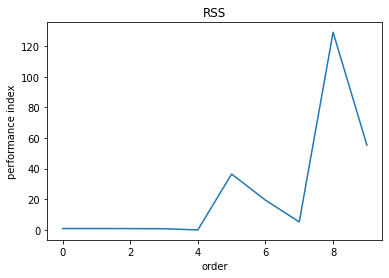

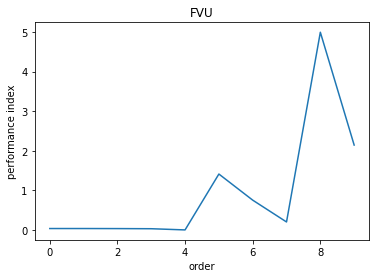

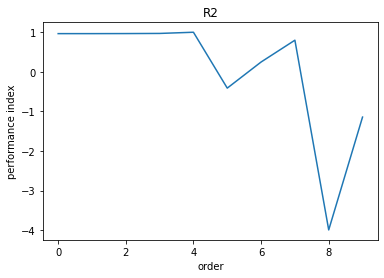

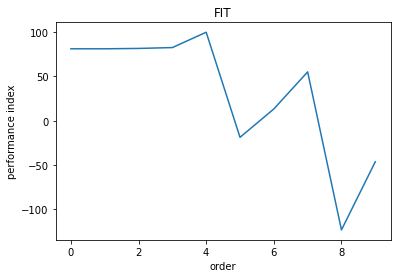

In [11]:
for i,test in enumerate(performance_tests):
    plt.figure()
    plt.plot(orders,p_i_LS_train[i,:])
    plt.title(p_t_names[i])
    plt.xlabel('order')
    plt.ylabel('performance index')
    

For RSS, FVU and R2 we see that orders 4 and below are quite good. For FIT we see the same trend, but it is clear that order 4 is best.

#### Test set:

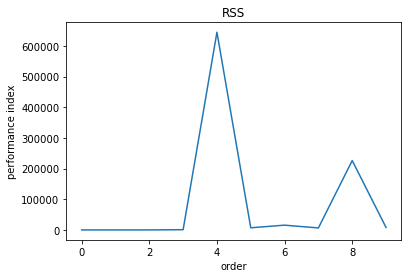

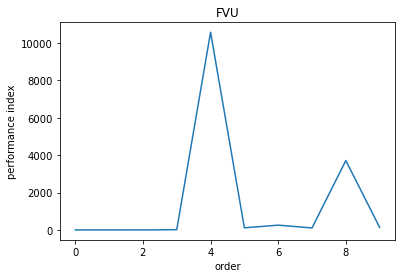

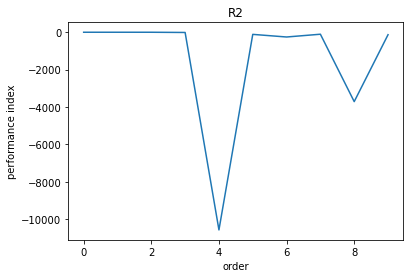

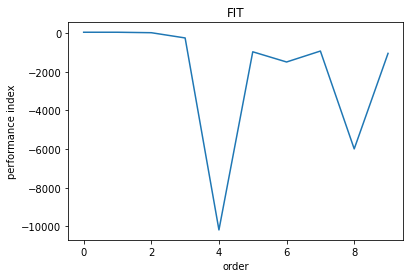

In [12]:
for i,test in enumerate(performance_tests):
    plt.figure()
    plt.plot(orders,p_i_LS_test[i,:])
    plt.title(p_t_names[i])
    plt.xlabel('order')
    plt.ylabel('performance index')

We see a serious increse in the performance test, especially for orders 4,5,6,7,8,9. This is the result of overfitting. To check which performance index that leads to the best performance, we plot again with the the remaining orders 0,1,2,3.

Text(0, 0.5, 'performance index')

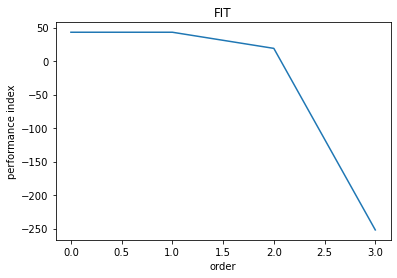

In [13]:
plt.figure()
plt.plot([0,1,2,3], performance_index(FIT,[0,1,2,3],models_ls,test_set['u'],test_set['y']))
plt.title(p_t_names[i])
plt.xlabel('order')
plt.ylabel('performance index')

It is clear the orders 2 and 3 functions like ass. By inspecting the real model, we determine that there is too little information in our training set to be able to get a good performance.

### MLE:

In [14]:
models_mle, params_mle = train(MLE,orders,train_set['u'],train_set['y'])

p_i_MLE_train = np.array([performance_index(test,orders,models_mle,train_set['u'],train_set['y']) for test in performance_tests])
p_i_MLE_test = np.array([performance_index(test,orders,models_mle,test_set['u'],test_set['y']) for test in performance_tests])

#### Train set

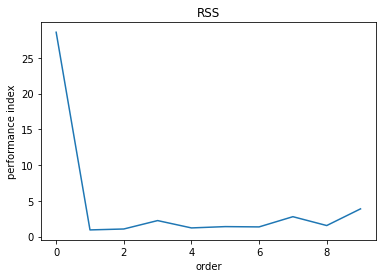

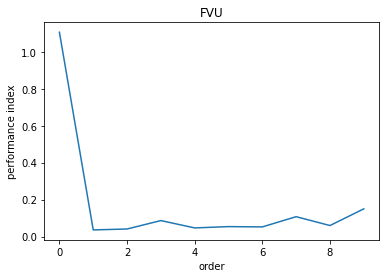

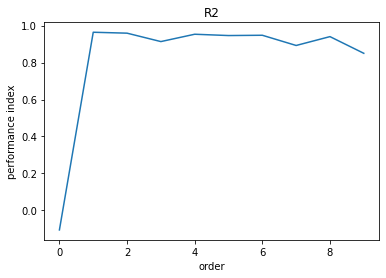

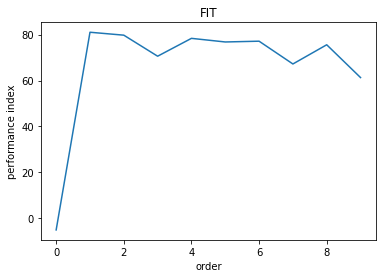

In [15]:
for i,test in enumerate(performance_tests):
    plt.figure()
    plt.plot(orders,p_i_MLE_train[i,:])
    plt.title(p_t_names[i])
    plt.xlabel('order')
    plt.ylabel('performance index')

Be get a much better performance from our training set when using MLE. It is clear that orders 1-8 are the best, while orders 0 and 9 performe much worse. 

#### Test set:

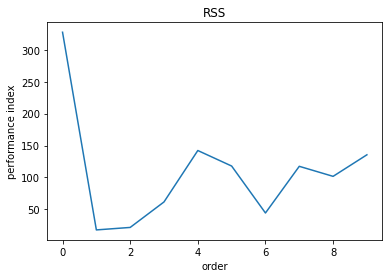

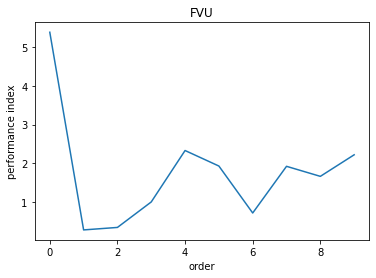

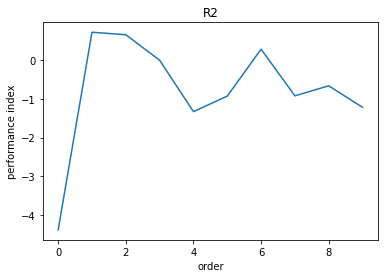

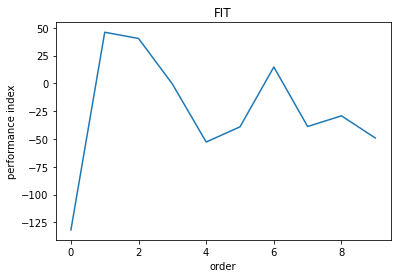

In [16]:
for i,test in enumerate(performance_tests):
    plt.figure()
    plt.plot(orders,p_i_MLE_test[i,:])
    plt.title(p_t_names[i])
    plt.xlabel('order')
    plt.ylabel('performance index')

Orders 1 and 2 function the best while the higher orders are affected by overfitting. By examening the FIT plot, we determine order 1 to performe the best. For order 0 we have high bias and low variance, which result in underfitting and low performance. While for order 3 and above be get a low bias but high variance, which give us overfitting. 